<a href="https://colab.research.google.com/github/sierprinsky/Short_projects/blob/main/Facial_expression_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/data

Dataset Description

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

train.csv contains two columns, "emotion" and "pixels". The "emotion" column contains a numeric code ranging from 0 to 6, inclusive, for the emotion that is present in the image. The "pixels" column contains a string surrounded in quotes for each image. The contents of this string a space-separated pixel values in row major order. test.csv contains only the "pixels" column and your task is to predict the emotion column.

**Import Libraries**

In [1]:
!pip install utils
from utils import *

!pip install livelossplot

!pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Import more libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import mlxtend
print(mlxtend.__version__)
 

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical



0.21.0


**Import database**

In [3]:
#Set kaggle API credentials
import os
os.environ['KAGGLE_USERNAME']='sergioad'
os.environ['KAGGLE_KEY']='b9bf2adc1df1d4830330ef3a967de111'

In [4]:
#Download dataset
! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

challenges-in-representation-learning-facial-expression-recognition-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
#Unzip file
! unzip /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip

Archive:  /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip
replace example_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace fer2013.tar.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace icml_face_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


**Plot sample image**

In [6]:
data = pd.read_csv('/content/icml_face_data.csv')

In [7]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


**Functions**

In [8]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

**Overview**

In [9]:
data[' Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name:  Usage, dtype: int64

**Prepare Data**

In [10]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

**Define training, validation and test data:**

In [11]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

**Reshape and scale the images:**

In [12]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

**Encoding of the target value:**

In [13]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

**Some Examples**

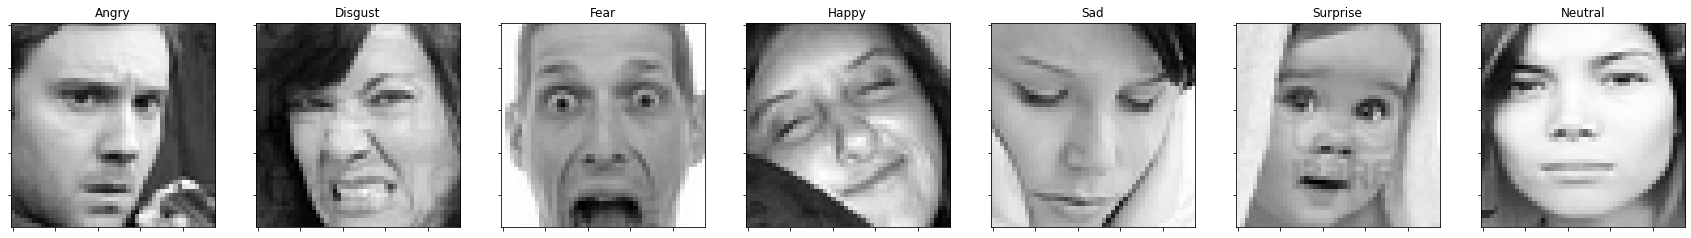

In [14]:
#All emotions
plot_all_emotions()

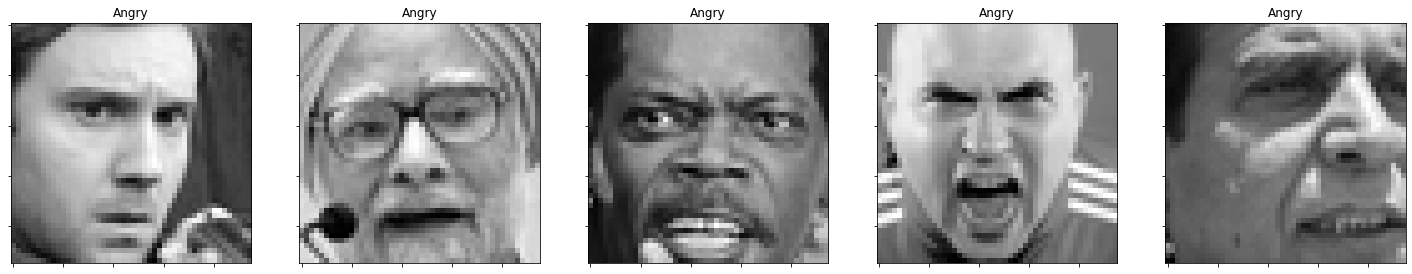

In [15]:
#Angry
plot_examples(label=0)

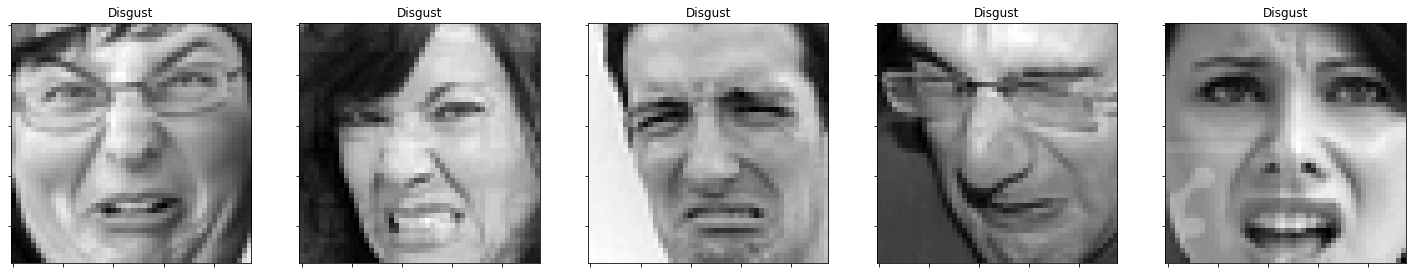

In [16]:
#Disgust
plot_examples(label=1)

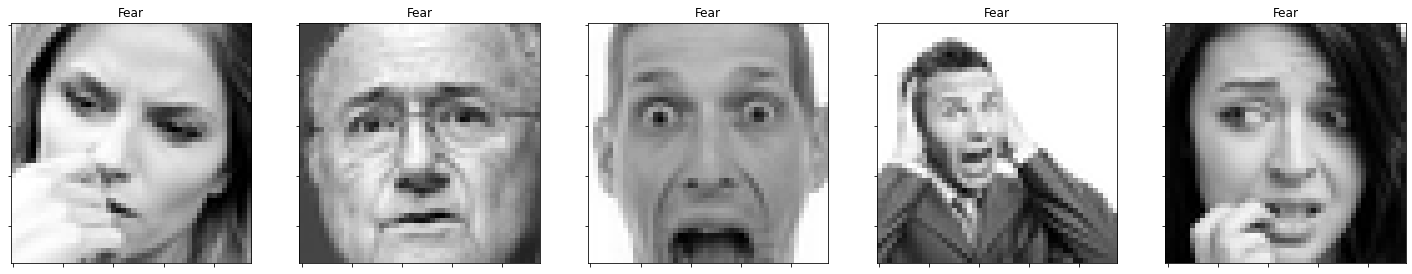

In [17]:
#Fear
plot_examples(label=2)

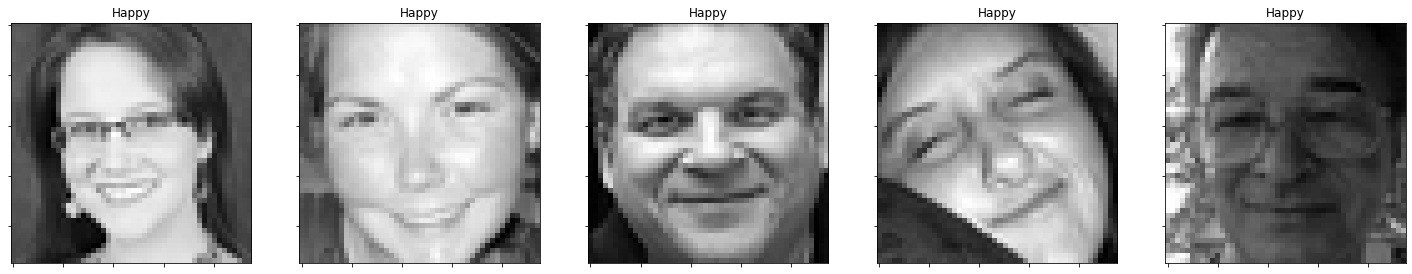

In [18]:
#Happy
plot_examples(label=3)

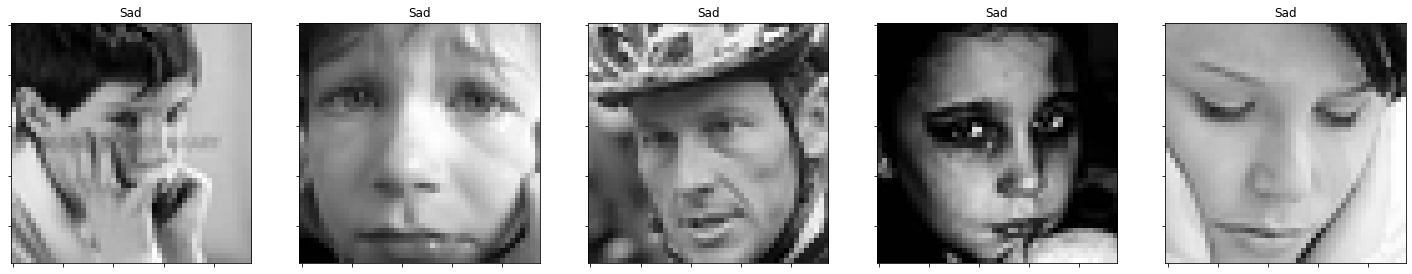

In [19]:
#Sad
plot_examples(label=4)

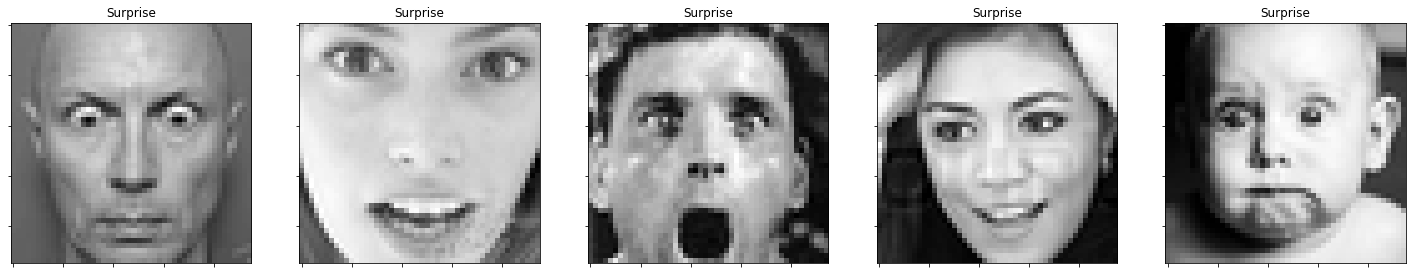

In [20]:
#Surprise
plot_examples(label=5)

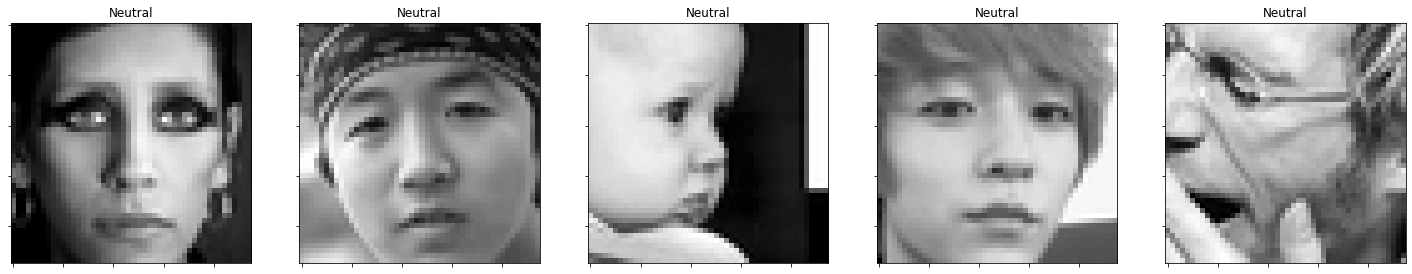

In [21]:
#Neutral
plot_examples(label=6)

**Distribution Of Labels**

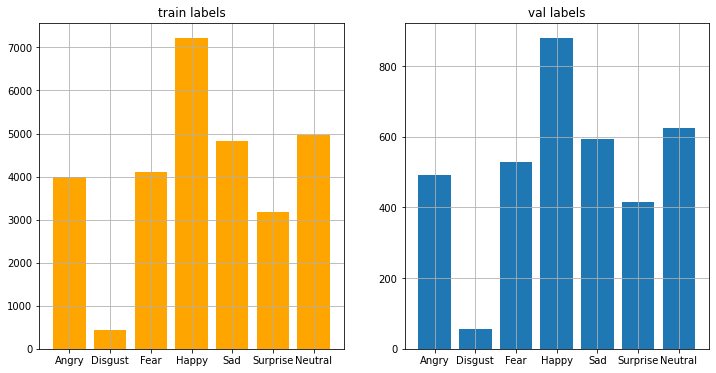

In [22]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

**Class Weights**

Calculate the class weights of the label distribution:

In [23]:
class_weight = dict(zip(range(0, 7), (((data[data[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data[data[' Usage']=='Training']['emotion'])).tolist()))

In [24]:
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.16823992476226968,
 5: 0.11045316799609878,
 6: 0.17294228290779895}

**Model**

We define a simple CNN model:

In [25]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [26]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 4096)              0

In [28]:
history = model.fit(train_images, train_labels,
                    validation_data=(val_images, val_labels),
                    class_weight = class_weight,
                    epochs=14,
                    batch_size=64)

Epoch 1/14
449/449 [==============================] - 95s 209ms/step - loss: 0.2701 - accuracy: 0.3060 - val_loss: 1.5846 - val_accuracy: 0.3973
Epoch 2/14
449/449 [==============================] - 95s 211ms/step - loss: 0.2301 - accuracy: 0.4322 - val_loss: 1.5411 - val_accuracy: 0.4177
Epoch 3/14
449/449 [==============================] - 94s 209ms/step - loss: 0.2118 - accuracy: 0.4777 - val_loss: 1.4136 - val_accuracy: 0.4692
Epoch 4/14
449/449 [==============================] - 94s 210ms/step - loss: 0.1984 - accuracy: 0.5124 - val_loss: 1.3406 - val_accuracy: 0.4979
Epoch 5/14
449/449 [==============================] - 97s 215ms/step - loss: 0.1885 - accuracy: 0.5373 - val_loss: 1.2885 - val_accuracy: 0.5183
Epoch 6/14
449/449 [==============================] - 93s 206ms/step - loss: 0.1801 - accuracy: 0.5590 - val_loss: 1.2639 - val_accuracy: 0.5283
Epoch 7/14
449/449 [==============================] - 92s 205ms/step - loss: 0.1714 - accuracy: 0.5801 - val_loss: 1.2966 - val_ac

In [29]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test caccuracy:', test_acc)

113/113 [==============================] - 3s 30ms/step - loss: 1.4403 - accuracy: 0.5375
test caccuracy: 0.5374756455421448


In [30]:
pred_test_labels = model.predict(test_images)

113/113 [==============================] - 3s 29ms/step


**Analyse Convergence**

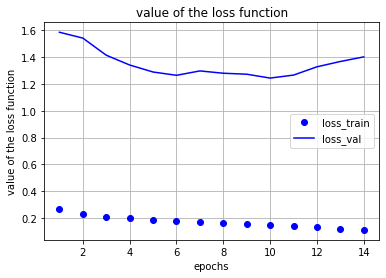

In [31]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

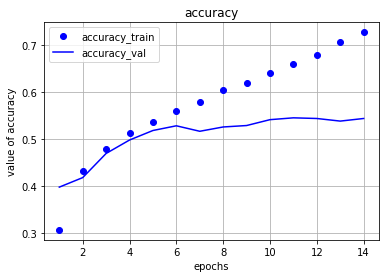

In [32]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

**Analyse Results**

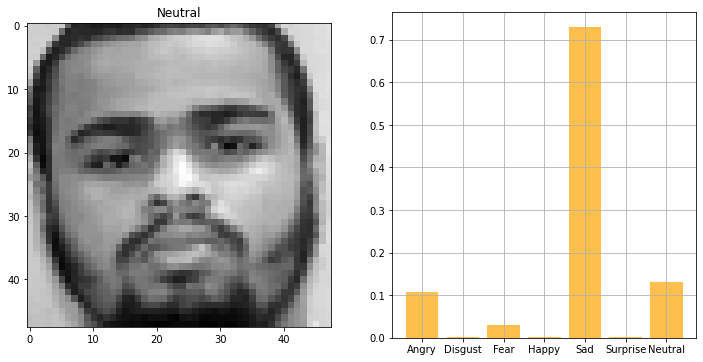

In [33]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 106)

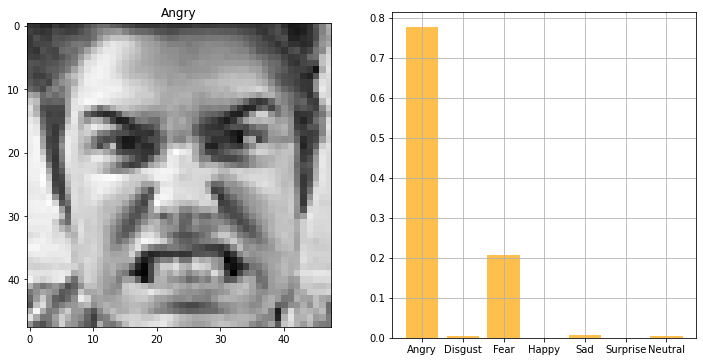

In [34]:
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 40)

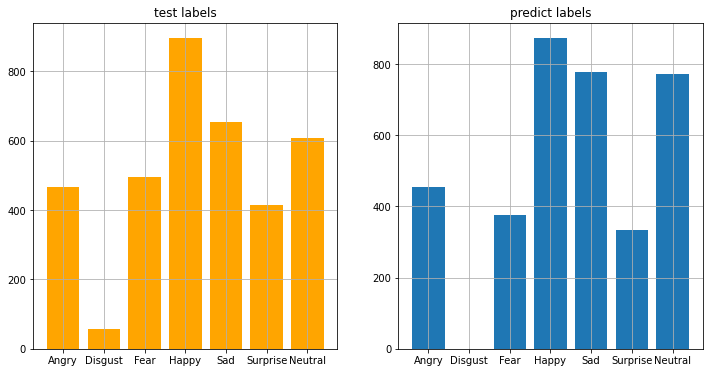

In [35]:
plot_compare_distributions(test_labels, pred_test_labels, title1='test labels', title2='predict labels')

**Analyse Wrong Prediction**

Analyse Wrong Prediction
The accuracy score is about 60% on the test set. So it is obvious to take focus on the wrong predictions. We want to extract details to improve the model.

In [36]:
df_compare = pd.DataFrame()
df_compare['real'] = test_labels.argmax(axis=1)
df_compare['pred'] = pred_test_labels.argmax(axis=1)
df_compare['wrong'] = np.where(df_compare['real']!=df_compare['pred'], 1, 0)

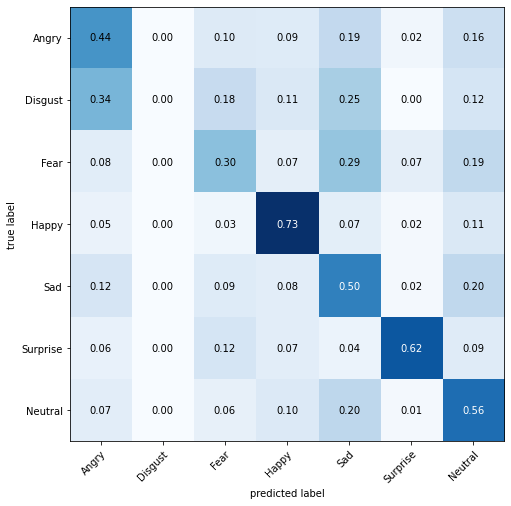

In [37]:
conf_mat = confusion_matrix(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1))

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()